# Using {mod}`biolord` for -omics data

This code presents an application of {mod}`biolord` to chromatin accessibility single-cell data.

We train a {class}`~biolord.Biolord` model on a fetal chromatin accessibility single-cell atlas {cite}`domcke:20` to obtain a meaningful disentangled latent representation.

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import os
import sys
import scanpy as sc
from muon import atac as ac
import anndata

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import biolord

## Setup the {class}`~anndata.AnnData`

In [2]:
atac = sc.read(
    "adata_atac.h5ad",
    backup_url="https://figshare.com/articles/dataset/atac-tissue-age-celltype/23702631",
)

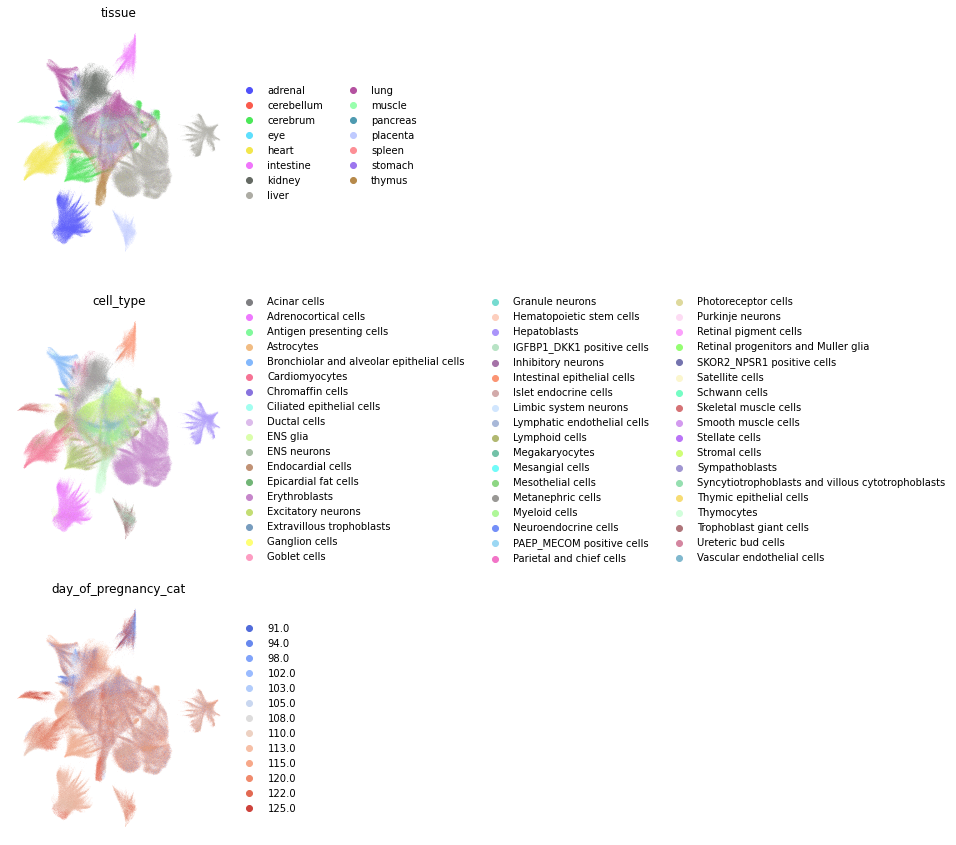

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(4, 15))
for i, c in enumerate(["tissue", "cell_type", "day_of_pregnancy_cat"]):
    sc.pl.umap(atac, color=[c], ax=axs[i], show=False)
    axs[i].set_axis_off()
plt.tight_layout()
plt.show()

By calling {meth}`biolord.Biolord.setup_anndata()` we set the supervised attributes used for disentanglement.
The function takes as input:

* `adata`: the adata object for the setting.
* `ordered_attributes_keys`: the keys in {attr}`~anndata.AnnData.obs` or {attr}`~anndata.AnnData.obsm` defining ordered attributes.
* `categorical_attributes_keys`: the keys in {attr}`~anndata.AnnData.obs` defining categorical attributes.
* `layer`: the key {attr}`~anndata.AnnData.layers` (or simply "X" for {attr}`~anndata.AnnData.X`) we want to take measured features from.

In [4]:
biolord.Biolord.setup_anndata(
    adata=atac,
    ordered_attributes_keys=["day_of_pregnancy"],
    categorical_attributes_keys=["tissue", "cell_type"],
    layer="counts"
)

## Run {class}`~biolord.Biolord`

### Instantiate a {class}`~biolord.Biolord` model 

We instantiate the model given the `module_params`.
These are parameters required to construct the model's module, the various networks included in a {class}`~biolord.Biolord` model. Here we make sure to pass `gene_likelihood=Poisson` to model the peak counts{cite}`martens:22`.


In [5]:
module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 16,
    "gene_likelihood": "poisson",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1
}

In [6]:
model = biolord.Biolord(
    adata=atac,
    n_latent=128,
    model_name="atac_poisson",
    module_params=module_params,
    split_key="split_random",
)

[rank: 0] Global seed set to 42


### Train the model

To train the model we provide `trainer_params`. These are paramters which dictate the training regime, e.g., learning rate, weight decay and scheduler type.

In [7]:
trainer_params = {
    "n_epochs_warmup": 0,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [8]:
model.train(
    max_epochs=100,
    batch_size=1024,
    plan_kwargs=trainer_params,
    early_stopping=False,
    enable_checkpointing=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 100/100: 100%|██████████| 100/100 [1:16:15<00:00, 44.93s/it, v_num=1, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=2.42e+3, unknown_attribute_penalty_loss=128, val_generative_mean_accuracy=0.812, val_generative_var_accuracy=0.125, val_biolord_metric=0.469, val_reconstruction_loss=2.44e+3, val_unknown_attribute_penalty_loss=6.07e-17]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:16:15<00:00, 45.76s/it, v_num=1, generative_mean_accuracy=0, generative_var_accuracy=0, biolord_metric=0, reconstruction_loss=2.42e+3, unknown_attribute_penalty_loss=128, val_generative_mean_accuracy=0.812, val_generative_var_accuracy=0.125, val_biolord_metric=0.469, val_reconstruction_loss=2.44e+3, val_unknown_attribute_penalty_loss=6.07e-17]


## Explore the latent space

### Obtain latent space representations

Concatenate all possible combinations of `cell_type`, `tissue` and `day_of_pregnancy`.
We need to treat differently the  _categorical_ and _ordered attributes_:
* _categorical_attributes_: We use {meth}`~biolord.Biolord.get_categorical_attribute_embeddings()` which takes as input `attribute_key` and provides the latent vectors of all categories.
* _ordered_attributes_: We use {meth}`~biolord.Biolord.get_ordered_attribute_embedding()` which requires along with `attribute_key` the `vals`, the desired values to get the vectors for.

In [10]:
attribute_keys_categorical = ["tissue", "cell_type"]
attribute_keys_continuous = ["day_of_pregnancy"]
attribute_keys = [*attribute_keys_categorical, *attribute_keys_continuous]

transf_embeddings_attributes = {}
for attribute_ in attribute_keys_categorical:
    transf_embeddings_attributes[attribute_] = sc.pp.scale(model.get_categorical_attribute_embeddings(attribute_key=attribute_))

for attribute_ in attribute_keys_continuous:
    transf_embeddings_attributes[attribute_] = sc.pp.scale(model.get_ordered_attribute_embedding(
        attribute_key=attribute_, 
        vals=np.sort(atac.obs[attribute_].unique())[:, np.newaxis]
    ))

attribute_model_keys = {}
attribute_model_keys_maps = {}
for attribute_ in attribute_keys_categorical:
    attribute_model_keys[attribute_] = list(model.categorical_attributes_map[attribute_].keys())
    attribute_model_keys_maps[attribute_] = model.categorical_attributes_map[attribute_]

for attribute_ in attribute_keys_continuous:
    cats = list(np.sort(atac.obs[attribute_].unique()))
    attribute_model_keys[attribute_] = cats
    attribute_model_keys_maps[attribute_] = {cat: i for i, cat in enumerate(cats)} 


keys = list(itertools.product(*[attribute_model_keys[attribute_] for attribute_ in attribute_keys]))

transf_embeddings_attributes_dict = {
    "_".join([str(k) for k in key_]): np.concatenate((
        [
            transf_embeddings_attributes[attribute_][attribute_model_keys_maps[attribute_][key_[ai]], :] for ai, attribute_ in enumerate(attribute_keys)
        ]
    ), 0)  
    for key_ in keys 
}


transf_embeddings_attributes = [
    np.concatenate((
[
            transf_embeddings_attributes[attribute_][attribute_model_keys_maps[attribute_][key_[ai]], :] for ai, attribute_ in enumerate(attribute_keys)
        ]
    ), 0)  
    for key_ in keys
]

We create an {class}`~anndata.AnnData` object to analyze the embedding. 

In [11]:
attr = np.asarray(transf_embeddings_attributes)
adata_emb = anndata.AnnData(X=attr, dtype=attr.dtype)
adata_emb.obs_names = ["_".join([str(k) for k in key]) for key in keys]
adata_emb.obs["tissue"] = [key[0] for key in keys]
adata_emb.obs["cell_type"] = [key[1] for key in keys]
adata_emb.obs["day_of_pregnancy"] = [key[2] for key in keys]
adata_emb

AnnData object with n_obs × n_vars = 10530 × 48
    obs: 'tissue', 'cell_type', 'day_of_pregnancy'

### Visualize inner attribute relationships

We first assess the correlations within each attribute

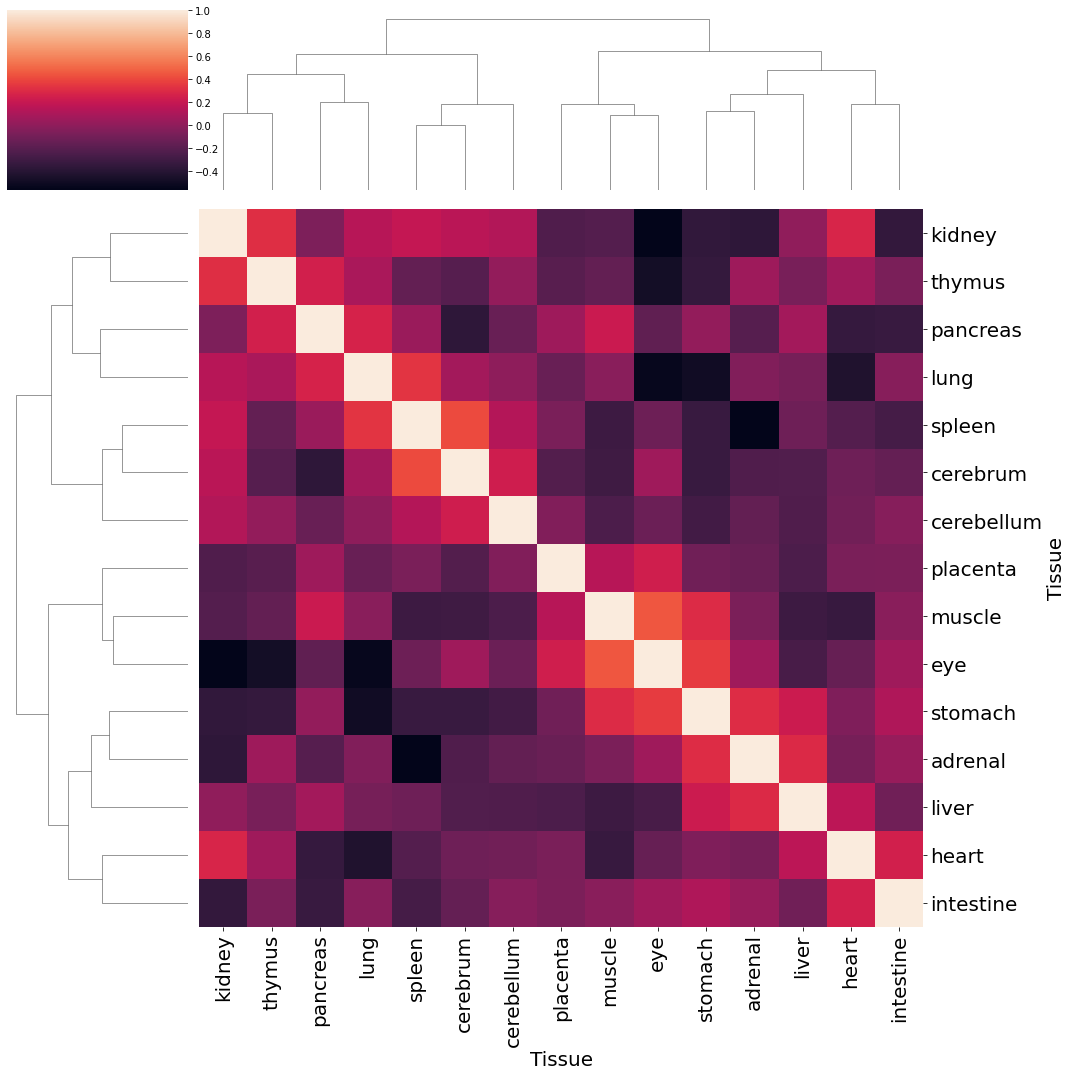

In [12]:
df = pd.DataFrame(attr, index=adata_emb.obs_names)
df = df.iloc[:, :16]
df["tissue"] = [key[0] for key in keys]
df_agg = df.groupby("tissue").mean().T
linkage = hc.linkage(df_agg.corr(), method='complete', optimal_ordering=True)
h = sns.clustermap(df_agg.corr(), row_linkage=linkage, col_linkage=linkage, yticklabels=1, xticklabels=1, figsize=(15, 15))
h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_yticklabels(), rotation=0, fontsize=20)
h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xticklabels(), rotation=90, fontsize=20)
h.ax_heatmap.set_ylabel("Tissue", fontsize=20)
h.ax_heatmap.set_xlabel("Tissue", fontsize=20)
plt.tight_layout()
plt.show()

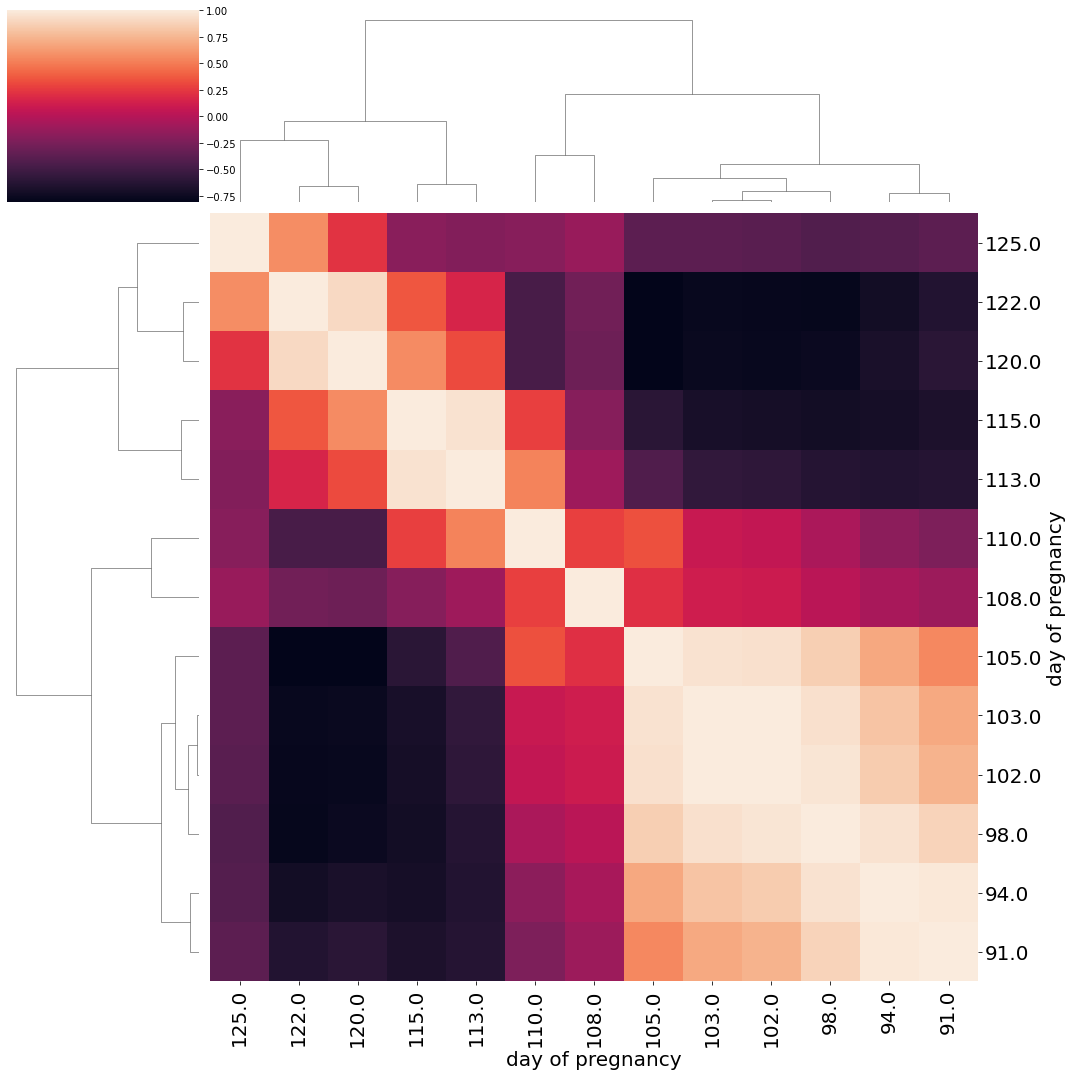

In [13]:
df = pd.DataFrame(attr, index=adata_emb.obs_names)
df = df.iloc[:, 32:]
df["day_of_pregnancy"] = [key[2] for key in keys]
df_agg = df.groupby("day_of_pregnancy").mean().T
linkage = hc.linkage(df_agg.corr(), metric="euclidean", method='complete', optimal_ordering=True)
h = sns.clustermap(df_agg.corr(), row_linkage=linkage, col_linkage=linkage, yticklabels=1, xticklabels=1, figsize=(15, 15))
h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_yticklabels(), rotation=0, fontsize=20)
h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xticklabels(), rotation=90, fontsize=20)
h.ax_heatmap.set_ylabel("day of pregnancy", fontsize=20)
h.ax_heatmap.set_xlabel("day of pregnancy", fontsize=20)

plt.tight_layout()
plt.show()

### Studying relations between attributes

We turn to study the relationships between attributes by considering the concatenation of the latent vectors, such that each data point represent a combination of `cell_type`, `tissue` and `day_of_pregnancy`. Importantly, we restrict this to combinations of `cell_type` and `tissue` observed in the data. 

In [14]:
adata_emb.obs["tissue"] = adata_emb.obs["tissue"].astype("category")
adata_emb.obs["cell_type"] = adata_emb.obs["cell_type"].astype("category")
adata_emb.obs["day_of_pregnancy"] = adata_emb.obs["day_of_pregnancy"].astype("category")
adata_emb.obs["day_of_pregnancy_cont"] = adata_emb.obs["day_of_pregnancy"].copy().astype(np.float16)
idx = []

for ti, tissue in enumerate(adata_emb.obs["tissue"].cat.categories):
    cts = atac[atac.obs["tissue"].isin([tissue])].obs["cell_type"].unique()
    
    idx.append(list(np.where((adata_emb.obs["tissue"].isin([tissue])) & (adata_emb.obs["cell_type"].isin(cts)))[0]))

adata_emb = adata_emb[np.concatenate(idx)]

In [16]:
sc.pp.pca(adata_emb)
sc.pp.neighbors(adata_emb, use_rep="X")
sc.tl.umap(adata_emb)

In [17]:
palletes = {
    "tissue":  [atac.uns["tissue_colors"][np.where(atac.obs["tissue"].cat.categories == cat)[0][0]] for cat in adata_emb.obs["tissue"].cat.categories],                                
    "cell_type": [atac.uns["cell_type_colors"][np.where(atac.obs["cell_type"].cat.categories == cat)[0][0]] for cat in adata_emb.obs["cell_type"].cat.categories],                                
    "day_of_pregnancy": [atac.uns["day_of_pregnancy_cat_colors"][np.where(atac.obs["day_of_pregnancy_cat"].cat.categories == cat)[0][0]] for cat in adata_emb.obs["day_of_pregnancy"].cat.categories],  
    }

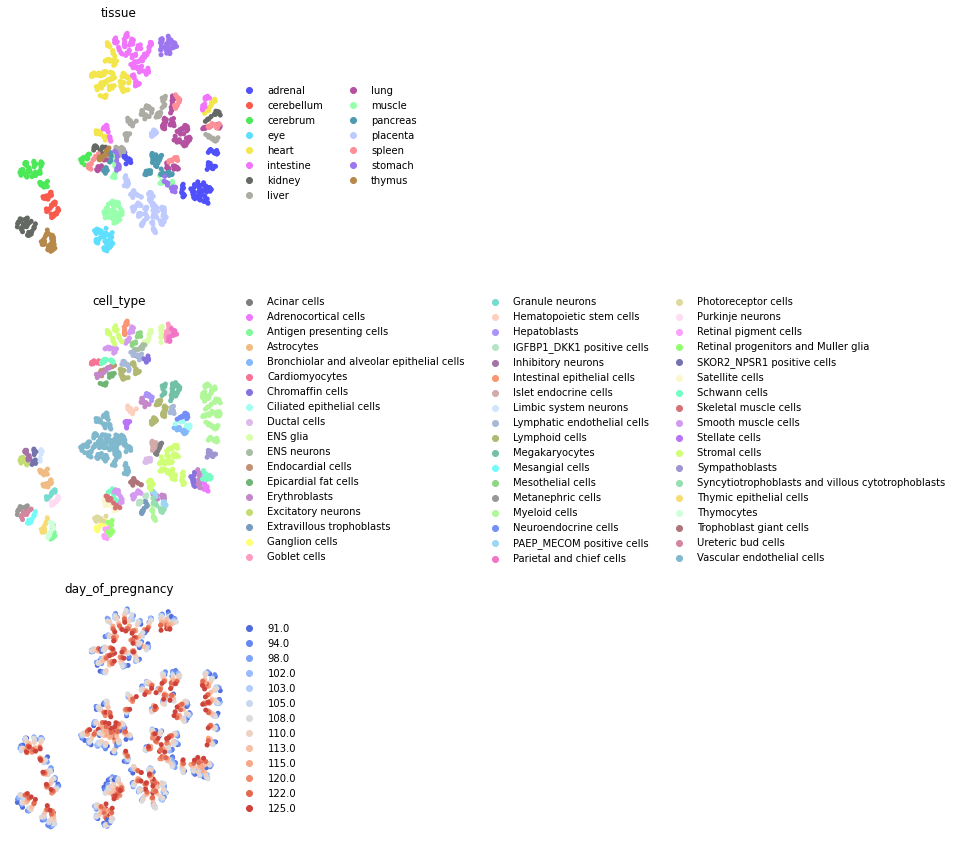

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(4, 15))
for i, c in enumerate(["tissue", "cell_type", "day_of_pregnancy"]):
    sc.pl.umap(
        adata_emb,
        color=[c], 
        size=100,
        palette=palletes[c],
        ax=axs[i], 
        show=False
    )
    axs[i].set_axis_off()
plt.tight_layout()
plt.show()